
# Beyond CFT: Attacks on the Network and Convergence 


So far we showed how gossip can withstand network imperfection. But what if the attacker deliberately splits and attacks the network?  


Beyond regular crashes, peer can behave in various ways violating the protocol: hide transactions, send bogus data, create Sybil entities etc.
The goal of a blockchain system is to withstand against a powerful adversary. 

To ensure that message will be seen by the peer, once the peer is back online it must fetch the data from the neighboring peers. But what if the neighboring nodes are malicious and will censor certain transactions?   

In the next notebooks we will cover techniques that help to detect/prevent malicious behaviour.



# Malicious gossip agent 

One of the goal of a blockchain system is to record transaction in a 'hard-to-tamper' way.

How can you achieve that in P2P settings?  
It is common in databases and blockchains to use cryptography to verify the integrities of the transactions.

Let's first create a malicious agent that will change the data of received transactions to split the network.  


In [216]:
# Initialize the experiment:
import networkx as nx
import p2psimpy as p2p
import warnings
warnings.filterwarnings('ignore')

# Load the previous experiment configurations
exper = p2p.BaseSimulation.load_experiment(expr_dir='crash_gossip')

Locations, topology, peer_services, serv_impl = exper


## Define malicious agents 
Let's first add malicious nodes randomly: 

In [217]:
# Change peer to a malicious 
from itertools import groupby
from random import sample

frac_malicious_nodes = 0.3 # 30 % of malicious nodes


def assign_malicious_peers(topology, mal_frac):
    type_dict = nx.get_node_attributes(topology, 'type')
    inv_type_dict = {k: {j for j, _ in list(v)}
                                for k, v in groupby(type_dict.items(), lambda x: x[1])}
    mal_nodes = sample(list(inv_type_dict['peer']), 
                       int(frac_malicious_nodes * len(inv_type_dict['peer'])))
    for b in mal_nodes:
        type_dict[b] = 'malicious'
        
    nx.set_node_attributes(topology, type_dict, 'type')
    
assign_malicious_peers(topology, frac_malicious_nodes)

## Define malicious services 

We will inherit a malicious gossip service that will relay the gossip message to one half of the network and the other half a tempered message (with different data). 



In [218]:
from p2psimpy.messages import *
from p2psimpy.consts import TEMPERED

class MaliciousGossipService(p2p.GossipService):
    
    
    def handle_message(self, msg):
        # Store the original message localy 
        self.peer.store('msg_time', msg.id, self.peer.env.now)
        self.peer.store('msg_data', msg.id, msg.data)

        if msg.ttl > 0:
            # Rely message further, modify the message
            exclude_peers = {msg.sender} | self.exclude_peers
            
            # Send the original message to one half of the network, 
            selected = self.peer.gossip(GossipMessage(self.peer, msg.id, msg.data, msg.ttl-1,
                                                      pre_task=msg.pre_task, post_task=msg.post_task), 
                                        self.fanout//2, 
                                        except_peers=exclude_peers, 
                                        except_type=self.exclude_types)
            # Change the message and send it to the other half
            new_data = TEMPERED
            exclude_peers = exclude_peers | set(selected)
            self.peer.gossip(GossipMessage(self.peer, msg.id, new_data, msg.ttl-1, 
                                           pre_task=msg.pre_task, post_task=msg.post_task), 
                             self.fanout//2, 
                             except_peers=exclude_peers, 
                             except_type=self.exclude_types)

##  Add malicious type and services 

We deliberately keep malicious nodes uncrashable. 


In [219]:
peer_services['peer'].service_map

{'BaseConnectionManager': None,
 'RandomDowntime': p2psimpy.config.DowntimeConfig,
 'RangedPullGossipService': p2psimpy.config.PullGossipConfig}

In [220]:


gossip_config = peer_services['peer'].service_map['RangedPullGossipService']
serv_impl['RangedPullGossipService'] = p2p.GossipService



peer_services['malicious'] = p2p.PeerType(peer_services['peer'].config,
                                      {p2p.BaseConnectionManager:None,
                                       MaliciousGossipService: gossip_config}
                                     )

## Run simulation 

Let's see how malicious agents together with crashing nodes affect the message dissemination. 

In [221]:
serv_impl

{'BaseConnectionManager': p2psimpy.services.connection_manager.BaseConnectionManager,
 'MessageProducer': p2psimpy.services.message_producer.MessageProducer,
 'RandomDowntime': p2psimpy.services.disruption.RandomDowntime,
 'RangedPullGossipService': p2psimpy.services.gossip.GossipService}

In [222]:
from p2psimpy.messages import GossipMessage

In [223]:
# Init Graph
sim = p2p.BaseSimulation(Locations, topology, peer_services, serv_impl)
sim.run(3_200)

# Analyze the storage data




## Message data

Let's see how this fraction of malicious nodes affected the network. 
We compare the received message with the original message, we report `True` if the message wasn't tampered `False` and otherwise. 



In [224]:
import pandas as pd

def message_data(sim, peer_id, storage_name):
    store = sim.peers[peer_id].storage[storage_name].txs
    for msg_id, tx in store.items():
        client_id, msg_num = msg_id.split('_')
        client_tx = sim.peers[int(client_id)].storage[storage_name].txs[msg_id]
        yield (int(msg_num), tx.data == client_tx.data)
        
def get_gossip_table(sim, storage_name, func):
    return pd.DataFrame({k: dict(func(sim, k, storage_name)) 
                         for k in set(sim.types_peers['peer'])}).sort_index()

    
df = get_gossip_table(sim, 'msg_data', message_data)
df

,3,4,5,7,8,9,11,12,13,14,16,17,20,21,22,23,24,25
1,True,True,False,False,False,True,True,False,True,True,True,False,True,True,True,False,False,False
2,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,False,True
3,True,True,True,False,False,False,False,True,False,False,False,True,True,True,True,True,True,False
4,False,True,False,False,False,False,NaN,False,False,False,True,False,True,True,False,True,False,False
5,True,True,True,True,True,False,True,True,False,False,True,False,True,False,True,True,False,True
6,False,False,NaN,False,False,False,True,False,False,False,True,NaN,True,True,False,True,False,False
7,True,True,True,False,True,False,True,False,True,NaN,False,NaN,True,True,False,True,False,True
8,True,True,True,True,True,True,NaN,True,True,True,True,True,False,NaN,True,True,True,True
9,True,True,True,True,True,NaN,True,True,True,True,False,True,True,True,True,NaN,True,True
10,True,True,True,False,True,False,True,False,False,True,True,True,True,True,True,True,False,True


In [225]:
df[df==False].count()

3     2
4     2
5     3
7     6
8     5
9     6
11    1
12    6
13    6
14    5
16    3
17    3
20    1
21    1
22    4
23    1
24    8
25    4
dtype: int64

Malicious nodes managed to trick some peers into accepting wrong data! As peers will write 'first-seen' value, adversary once having advantage over the network can perfectly split the network. 

How to deal with this?

# Signing messages

First of all, messages themselves must be verified on their **integrity** and **authenticity**. 
[Digital signatures](https://en.wikipedia.org/wiki/Digital_signature) are perfect match for this and hence all blockchain systems use them. 

We will modify the code to simulate the signed messages. We will not use an actual crytpographic protocol since we care about only two things for our simulation: 
- It takes time to verify and sign messages. 
- Peers should store and forward only valid messages. 



## Simulating digital signatures 

We will show an example by building a crypto validator for 456 bits [EdDSA (Ed448)](https://en.wikipedia.org/wiki/EdDSA) (one of the most popular digital signatures in the wild).
On a regular laptop it takes usually less than 1 millisecond to verify a signature. Let's take the near worse case.  


This is not real. 

We will integrate a verification task into the message itself. 
Peer before triggering other services will first run the `pre_task`.  

Since the message is first created by MessageProducer we will add a task in the configuration.



In [226]:
from p2psimpy.consts import TEMPERED
from p2psimpy.config import Config, Func, Dist


conf = peer_services['client'].service_map['MessageProducer']


def validate_task(msg, peer):
    gen_dist = Dist('norm', (1, 0.2)) # time it takes to verify the message

    yield peer.env.timeout(gen_dist.get())
    if msg.data == TEMPERED:
        # You can decide what to do in this case.
        return False
    return True


class MsgConfig(Config):
    pre_task = Func(validate_task)
    init_ttl = conf.init_ttl if conf else 3
    
    
peer_services['client'].service_map['MessageProducer'] = MsgConfig

In [227]:
# Run the simulation with a modificed message producer 

sim2 = p2p.BaseSimulation(Locations, topology, peer_services, serv_impl)
sim2.run(3_200)


In [228]:
df = get_gossip_table(sim2, 'msg_data', message_data)
df

,3,4,5,7,8,9,11,12,13,14,16,17,20,21,22,23,24,25
1,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
5,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
6,True,NaN,NaN,True,True,True,True,NaN,True,True,NaN,True,True,True,True,True,NaN,NaN
7,True,True,NaN,True,True,True,NaN,True,True,True,True,True,True,True,True,NaN,True,True
8,True,True,True,True,True,True,True,NaN,True,True,True,True,True,True,True,True,True,True
9,NaN,True,True,True,True,True,True,NaN,NaN,True,NaN,True,True,NaN,True,True,True,True
10,NaN,NaN,NaN,True,True,True,True,True,NaN,NaN,True,NaN,True,True,NaN,NaN,True,NaN


In [229]:
sim2.peers[12].storage['msg_data'].txs

{'26_1': GossipMessage:JOHBJHQUIADUBPQEUSNF,
 '26_2': GossipMessage:EZUTKSVNPITMUBAPALIR,
 '26_3': GossipMessage:YDERDFFMAWCQHLKEJNRR,
 '26_4': GossipMessage:OTQYNVZMAFCPLIYOLCTM,
 '26_5': GossipMessage:CEJPPUTBSHEBCHDUQHUV,
 '26_7': GossipMessage:DUBSYZCVPGQGSVDHKRQH,
 '26_10': GossipMessage:FBLQQVCACIYGCTUUXIVW}

Now malicious nodes cannot change the message. They need to explore other attack strategies!
The malicious nodes can delay messages, hide them, freeriding in a gossip (only listening). 
Together with network attack this can create a dangerous combination. 

Let us consider a case where an honest node is surrounded by malicious nodes (all network connections are with malicious nodes) that will hide certain transactions. As a result, peer will not receive crucial transactions that might affect it's decision making process. This attack is also called **Eclipse attack**.   

In reality, almost nothing stops one malicious node from running multiple instances and poison the whole network. This attack is called **Sybil Attack**. 




### Exercises


- Explore the limits of the gossip protocol. What is the maximum number of malicious nodes a protocol can tolerate? 
- Try to eclipse attack some peer, make sure he doesn't get any message, or one specific message (censor)? 



## Eclipse
In the eclipse attack in a P2P environment, a malicious bootstrap node could respond to a peer request with other malicious nodes and thus surround the target node. For simplicity, here we will work with a random given topology, select a node at random and make its neighbors malicious.

In [230]:
# Initialize the experiment:
import networkx as nx
import p2psimpy as p2p
import warnings
warnings.filterwarnings('ignore')

# Load the previous experiment configurations
exper = p2p.BaseSimulation.load_experiment(expr_dir='crash_gossip')

Locations, topology, peer_services, serv_impl = exper


In [231]:
# Change peer to a malicious 
from itertools import groupby
from random import sample, choice



def isolate_node(topology):
    type_dict = nx.get_node_attributes(topology, 'type')
    inv_type_dict = {k: {j for j, _ in list(v)}
                                for k, v in groupby(type_dict.items(), lambda x: x[1])}

    #Avoid selecting neighbors of clients to not turn clients malicious
    client_neighbors = set()
    for c in inv_type_dict['client']:
        client_neighbors.update(list(topology.neighbors(c)))
    candidates = list(inv_type_dict['peer'].difference(client_neighbors))
    # Try to minimize number of malicious nodes in total by selecting nodes with few neighbors
    candidates = sorted(candidates,key=lambda x:len(list(topology.neighbors(x))))
    unlucky_node = choice(candidates[:5])
    
    mal_nodes = topology.neighbors(unlucky_node)

    for b in mal_nodes:
        type_dict[b] = 'malicious'
        
    nx.set_node_attributes(topology, type_dict, 'type')
    return unlucky_node
    
unlucky_node = isolate_node(topology)

In [232]:
def visualize_graph(G, ax=None):
    master_nodes = [n for (n,ty) in \
    nx.get_node_attributes(G,'type').items() if ty == 'peer']
    client_nodes = [n for (n,ty) in \
        nx.get_node_attributes(G,'type').items() if ty == 'client']
    malicious_nodes = [n for (n,ty) in \
        nx.get_node_attributes(G,'type').items() if ty == 'malicious']

    pos = nx.kamada_kawai_layout(G)
    
    nx.draw_networkx_nodes(G, pos, nodelist=malicious_nodes, \
        node_color='yellow', node_shape='o', node_size=500, ax=ax)
    nx.draw_networkx_nodes(G, pos, nodelist=master_nodes, \
        node_color='blue', node_shape='o', node_size=500, ax=ax)
    nx.draw_networkx_nodes(G, pos, nodelist=client_nodes,  \
        node_color='green', node_shape='^', node_size=500, label=1, ax=ax)
    nx.draw_networkx_nodes(G, pos, nodelist=[unlucky_node],  \
        node_color='red', node_shape='o', node_size=500, alpha=0.5, label=1, ax=ax)
    nx.draw_networkx_labels(G, pos, labels={k:k for k in master_nodes}, font_color='w', ax=ax)
    nx.draw_networkx_labels(G, pos, labels={k:k for k in malicious_nodes}, font_color='b', ax=ax)
    
    nx.draw_networkx_edges(G, pos, edgelist=G.subgraph(master_nodes).edges(), width=1.5, ax=ax)
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(nbunch=malicious_nodes), width=1.5, ax=ax)
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(nbunch=client_nodes),  style='dotted', ax=ax)


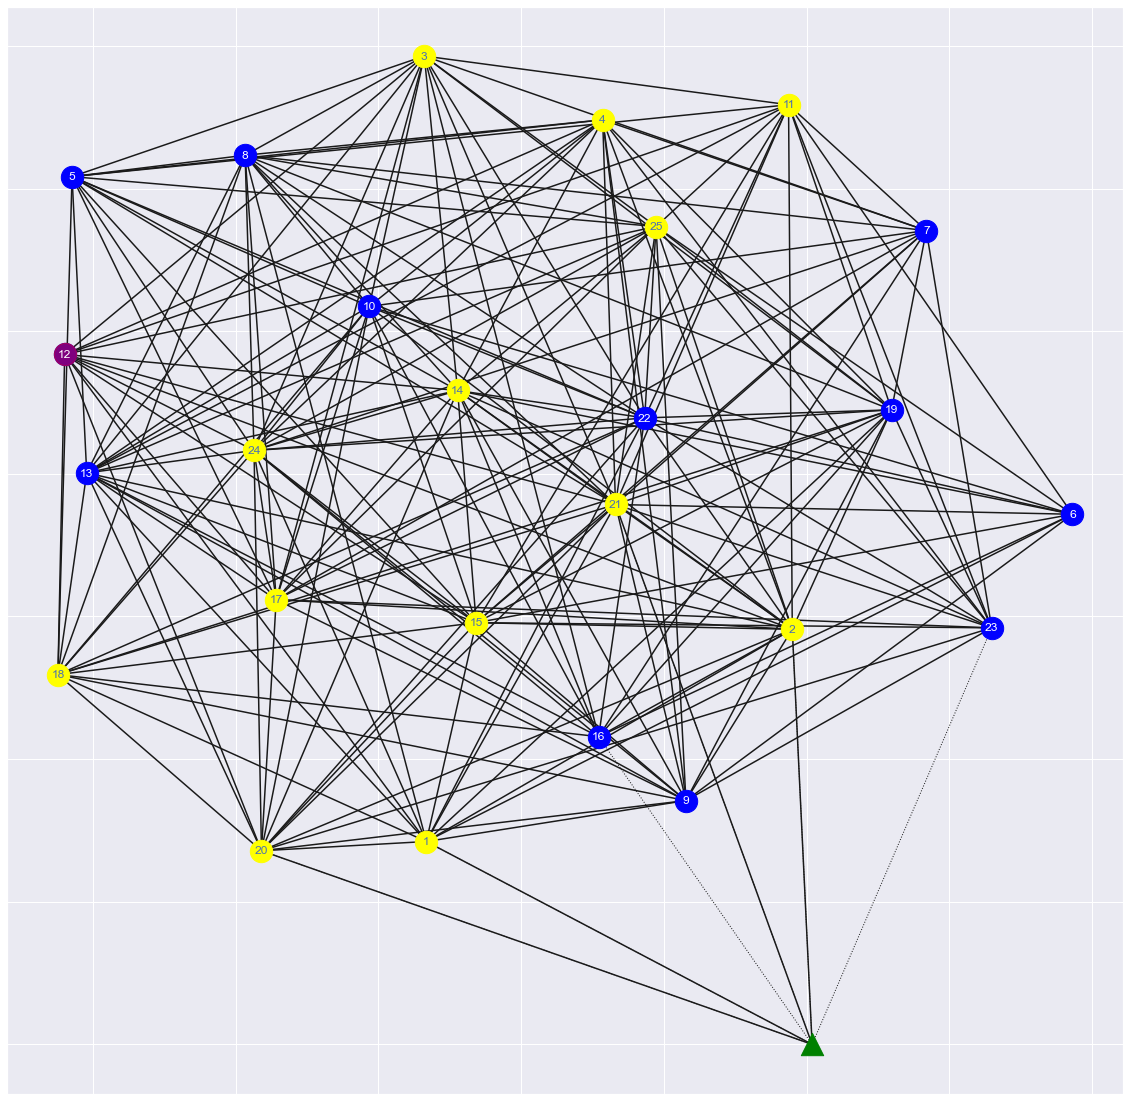

In [233]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(20,20))
visualize_graph(topology)

In [234]:
from p2psimpy.consts import TEMPERED
from p2psimpy.config import Config, Func, Dist

class MaliciousEclipseService(p2p.GossipService):
    
    def __init__(self, *args, **kwargs):
        self.exclude_peers_list = kwargs.pop("exclude_peers_list")
        self.censor_message_ids = kwargs.pop("censor_message_ids")
        self.opration_mode = kwargs.pop("operation_mode")
        super(MaliciousEclipseService, self).__init__(*args, **kwargs)

    
    def handle_message(self, msg):
        # Store the original message localy 
        self.peer.store('msg_time', msg.id, self.peer.env.now)
        self.peer.store('msg_data', msg.id, msg.data)
        
        exclude_targets = set()
        if self.opration_mode == "eclipse":
            for p in self.peer._get_connections():
                if p.peer_id in self.exclude_peers_list:
                    exclude_targets.add(p)
        else:
            if msg.id.split("_")[1] in self.censor_message_ids:
                for p in self.peer._get_connections():
                    if p.peer_id in self.exclude_peers_list:
                        exclude_targets.add(p)

                
        
        

        if msg.ttl > 0:
            # Rely message further, modify the message
            exclude_peers = {msg.sender} | self.exclude_peers | exclude_targets

            
            # Send the original message to one half of the network, 
            selected = self.peer.gossip(GossipMessage(self.peer, msg.id, msg.data, msg.ttl-1,
                                                      pre_task=msg.pre_task, post_task=msg.post_task), 
                                        self.fanout//2, 
                                        except_peers=exclude_peers, 
                                        except_type=self.exclude_types)
            # Change the message and send it to the other half
            new_data = TEMPERED
            exclude_peers = exclude_peers | set(selected)
            self.peer.gossip(GossipMessage(self.peer, msg.id, new_data, msg.ttl-1, 
                                           pre_task=msg.pre_task, post_task=msg.post_task), 
                             self.fanout//2, 
                             except_peers=exclude_peers, 
                             except_type=self.exclude_types)

In [235]:
class MaliciousGossipConfig(Config):
    exclude_peers_list = [unlucky_node]
    censor_message_ids = ['1','2','3','4','5']
    operation_mode = 'eclipse' # 'censor' or 'eclipse'
    exclude_types={'client',}

In [236]:
serv_impl['RangedPullGossipService'] = p2p.GossipService



peer_services['malicious'] = p2p.PeerType(peer_services['peer'].config,
                                      {p2p.BaseConnectionManager:None,
                                       MaliciousEclipseService: MaliciousGossipConfig}
                                     )

In [237]:
# Init Graph
from p2psimpy.messages import GossipMessage
sim = p2p.BaseSimulation(Locations, topology, peer_services, serv_impl)
sim.run(3_200)

In [238]:
import pandas as pd

def message_data(sim, peer_id, storage_name):
    store = sim.peers[peer_id].storage[storage_name].txs
    for msg_id, tx in store.items():
        client_id, msg_num = msg_id.split('_')
        client_tx = sim.peers[int(client_id)].storage[storage_name].txs[msg_id]
        yield (int(msg_num), tx.data == client_tx.data)
        
def get_gossip_table(sim, storage_name, func):
    return pd.DataFrame({k: dict(func(sim, k, storage_name)) 
                         for k in set(sim.types_peers['peer'])}).sort_index()

    
df = get_gossip_table(sim, 'msg_data', message_data)
df

,5,6,7,8,9,10,12,13,16,19,22,23
1,True,True,False,True,False,True,NaN,False,True,True,True,True
2,True,True,False,False,False,False,NaN,True,True,True,True,True
3,False,True,True,False,False,False,NaN,True,True,False,False,False
4,True,False,False,True,False,False,NaN,False,True,True,False,True
5,False,True,False,False,False,True,NaN,True,True,False,False,True
6,True,True,True,True,True,True,NaN,True,True,True,True,True
7,False,True,True,True,True,True,NaN,False,True,True,True,False
8,False,NaN,True,True,False,True,NaN,False,True,True,True,True
9,False,False,True,False,False,False,NaN,False,True,NaN,False,True
10,False,True,False,True,True,True,NaN,False,False,False,False,True


We can see that the malicious nodes continue poisoning the network, and on top they either completely hide information from the victim node or succesfully censor speficic messages. In the first case, the victim node does not receive any messages at all.